# What sells a car?

We're an analyst at Crankshaft List. Hundreds of free advertisements for vehicles are published on your site every day. You need to study data collected over the last few years and determine which factors influence the price of a vehicle.

## Initialization

In [2]:
# Loading all the libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
from datetime import datetime

### Load data

In [3]:
# Load the data file into a DataFrame

data = pd.read_csv('/datasets/vehicles_us.csv')

### Explore initial data

The dataset contains the following fields:
- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, diesel, etc.
- `odometer` — the vehicle's mileage when the ad was published
- `transmission`
- `paint_color`
- `is_4wd` — whether the vehicle has 4-wheel drive (Boolean type)
- `date_posted` — the date the ad was published
- `days_listed` — from publication to removal

In [4]:
# print the general/summary information about the DataFrame
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [5]:
# print a sample of data
data.head(5)


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


Price should be a float dtype, and lets check on the NaN in model year. Lets also change is_4wd to True and False. There is also NaN's in paint_color, and odometer. 

Columns with inaccurate data types:
Price, is_4wd, odometer, cylinders, date_posted should be in datetime.

Columns with Missing Values:

is_4wd, odometer, model_year, Paint_color

### Conclusions and further steps

The Model looks pretty typical. Fuel looks pretty normal as well. Type also looks fine. Date_posted and days_listed look fine as well. Next we clean up the data types, find fixes for the missing values and start our analysis. 

## Treat missing values (if any)

In [5]:
data['is_4wd'].astype('bool')
data['is_4wd'].fillna(value= False, inplace= True)
data['is_4wd'].replace(to_replace= 1.0, value= True, inplace= True)
data['price'].astype('float')
data['paint_color'].fillna('Unknown Color', inplace= True)
data.isna().sum()

price              0
model_year      3619
model              0
condition          0
cylinders       5260
fuel               0
odometer        7892
transmission       0
type               0
paint_color        0
is_4wd             0
date_posted        0
days_listed        0
dtype: int64

In [6]:
data['model_year'] = data['model_year'].fillna(data.groupby('model')['model_year'].transform('median'))
data['cylinders'] = data['cylinders'].fillna(data.groupby('model')['cylinders'].transform('median'))
data['odometer'] = data['odometer'].fillna(data.groupby('model_year')['odometer'].transform('mean'))

This code snippet 
data['odometer'] = data['odometer'].fillna(data.groupby('model')['model_year'].transform('mean'))
fills missing values with mean odometer by year

SO I changed the code snippet from data['odometer'] = data['odometer'].fillna(data.groupby('model')['model_year'].transform('mean'))
to data['odometer'] = data['odometer'].fillna(data.groupby('model')['odometer'].transform('mean'))

## Fix data types

In [7]:
data['date_posted_datetime'] = pd.to_datetime(data['date_posted'])
data['model_year_datetime'] = pd.to_datetime(data['model_year'])


## Enrich data

In [8]:
# Add datetime values for when the ad was placed
data['ad_placed'] = data['date_posted_datetime'].dt.year
data['ad_placed']

0        2018
1        2018
2        2019
3        2019
4        2019
         ... 
51520    2018
51521    2018
51522    2018
51523    2018
51524    2018
Name: ad_placed, Length: 51525, dtype: int64

In [9]:
# Add the vehicle's age when the ad was placed
data['vehicle_age_for_ad'] = (data['date_posted_datetime'].dt.year -data['model_year'])+1
data['vehicle_age_for_ad']

0         8.0
1         8.0
2         7.0
3        17.0
4         3.0
         ... 
51520     6.0
51521    17.0
51522    10.0
51523     6.0
51524     5.0
Name: vehicle_age_for_ad, Length: 51525, dtype: float64

In [10]:
# Add the vehicle's average mileage per year
data['vehicle_avg_mileage'] = (data['odometer'] / (data['vehicle_age_for_ad']))
data['vehicle_avg_mileage'] 

0        18125.000000
1        11088.125000
2        15714.285714
3         9533.632413
4        26967.666667
             ...     
51520    14689.333333
51521    10676.470588
51522    12800.000000
51523    23262.166667
51524    18729.740664
Name: vehicle_avg_mileage, Length: 51525, dtype: float64

In [11]:
# It might help to replace the condition values with something that can be manipulated more easily
data['condition'].unique() #'good', 'like new', 'fair', 'excellent', 'salvage', 'new'
def value_formatting(condition):
        if condition== 'salvage':
            return 1
        elif condition== 'fair':
            return 2
        elif condition== 'good':
            return 3
        elif condition== 'excellent':
            return 4
        elif condition== 'like new':
            return 5
        elif condition== 'new':
            return 6
data['conditional_values'] = data['condition'].apply(value_formatting)

In [12]:
data['paint_color'].unique()#'Unknown Color', 'white', 'red', 'black', 'blue', 'grey', 'silver','custom', 'orange', 'yellow', 'brown', 'green', 'purple'
def color_formatting(condition):
    if condition== 'Unknown Color':
        return 0
    elif condition== 'black':
        return 1
    elif condition== 'grey':
        return 2
    elif condition== 'silver':
        return 3
    elif condition== 'white':
        return 4
    elif condition== 'red':
        return 5
    elif condition== 'brown':
        return 6
    elif condition== 'orange':
        return 7
    elif condition== 'yellow':
        return 8
    elif condition== 'green':
        return 9
    elif condition== 'blue':
        return 10
    elif condition== 'purple':
        return 11
    elif condition== 'custom':
        return 12
data['paint_color_values'] = data['paint_color'].apply(color_formatting)
        

## Check clean data

In [13]:
# print the general/summary information about the DataFrame
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   price                 51525 non-null  int64         
 1   model_year            51525 non-null  float64       
 2   model                 51525 non-null  object        
 3   condition             51525 non-null  object        
 4   cylinders             51525 non-null  float64       
 5   fuel                  51525 non-null  object        
 6   odometer              51524 non-null  float64       
 7   transmission          51525 non-null  object        
 8   type                  51525 non-null  object        
 9   paint_color           51525 non-null  object        
 10  is_4wd                51525 non-null  bool          
 11  date_posted           51525 non-null  object        
 12  days_listed           51525 non-null  int64         
 13  date_posted_date

In [14]:
# print a sample of data
data.sample(10)
data['model_year']=data.apply(lambda x:int(x['model_year'])   ,axis=1)
data['vehicle_age_for_ad'] = data['vehicle_age_for_ad'].fillna(data['vehicle_age_for_ad'].mean())
data['vehicle_avg_mileage'] = data['vehicle_avg_mileage'].fillna(data['vehicle_avg_mileage'].mean())
data['vehicle_age_for_ad'] = data['vehicle_age_for_ad'].astype(int)
data['vehicle_avg_mileage'] = data['vehicle_avg_mileage'].astype(int)

I added this to the code to make that happen
data['vehicle_age_for_ad'].astype(int)
data['vehicle_avg_mileage'].astype(int)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   price                 51525 non-null  int64         
 1   model_year            51525 non-null  int64         
 2   model                 51525 non-null  object        
 3   condition             51525 non-null  object        
 4   cylinders             51525 non-null  float64       
 5   fuel                  51525 non-null  object        
 6   odometer              51524 non-null  float64       
 7   transmission          51525 non-null  object        
 8   type                  51525 non-null  object        
 9   paint_color           51525 non-null  object        
 10  is_4wd                51525 non-null  bool          
 11  date_posted           51525 non-null  object        
 12  days_listed           51525 non-null  int64         
 13  date_posted_date

## Study core parameters

The parameters are
- Price
- The vehicle's age when the ad was placed
- Mileage
- Number of cylinders
- Condition

In [16]:
data['vehicle_avg_mileage'].max()

373200

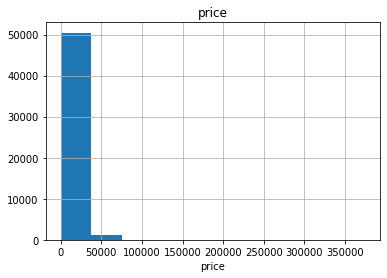

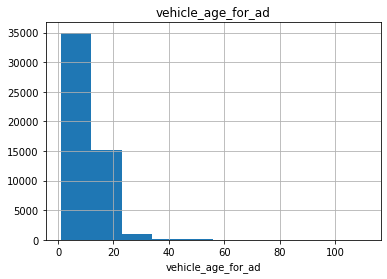

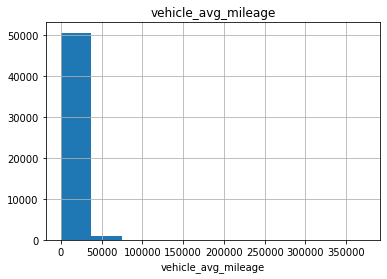

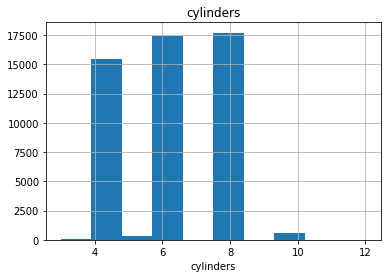

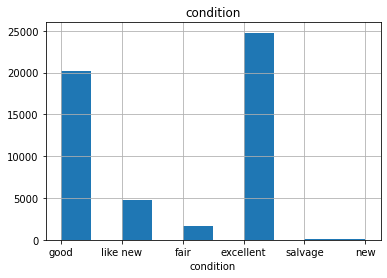

<Figure size 432x288 with 0 Axes>

In [17]:
for i in ['price','vehicle_age_for_ad','vehicle_avg_mileage','cylinders','condition']:
    data[i].hist()
    plt.title(i)
    plt.xlabel(i)
    plt.figure()

Graph Conclousion: 
These histograms show the outliers and form of the data. The ouliers for the data in price, vehicle_age_for_ad, vehicile_avg_mileage the shortest section is the outlier section.

<AxesSubplot:xlabel='days_listed', ylabel='price'>

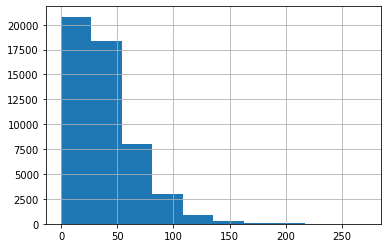

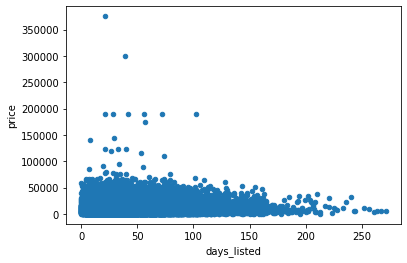

In [18]:
#
data['days_listed'].hist()
data.plot.scatter(x='days_listed', y='price')


In [19]:
data['condition']

0             good
1             good
2         like new
3             fair
4        excellent
           ...    
51520     like new
51521      salvage
51522    excellent
51523         good
51524         good
Name: condition, Length: 51525, dtype: object

In [20]:
#
for i in ['price','ad_placed','vehicle_avg_mileage','cylinders']:
    #outliers
    data2 = data[(np.abs(stats.zscore(data[i])) > 3)]
    print('outliers for '+i+' are')
    print(data2[i])

outliers for price are
188      52000
360      44900
434      47995
536      46988
610      45500
         ...  
50715    44995
50994    57000
51096    42900
51122    48000
51291    47995
Name: price, Length: 619, dtype: int64
outliers for ad_placed are
Series([], Name: ad_placed, dtype: int64)
outliers for vehicle_avg_mileage are
95       52992
220      74229
517      45694
545      60693
579      51683
         ...  
51035    40858
51109    61593
51212    55621
51397    44900
51446    50502
Name: vehicle_avg_mileage, Length: 723, dtype: int64
outliers for cylinders are
12615    12.0
44117    12.0
Name: cylinders, dtype: float64


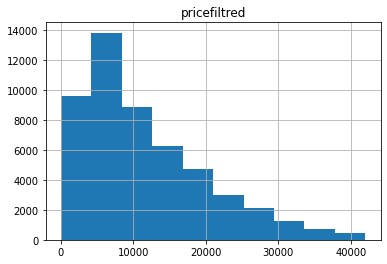

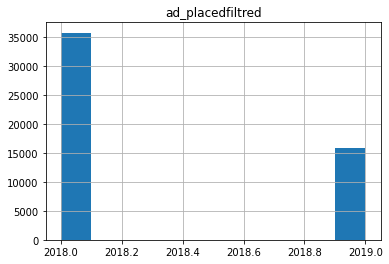

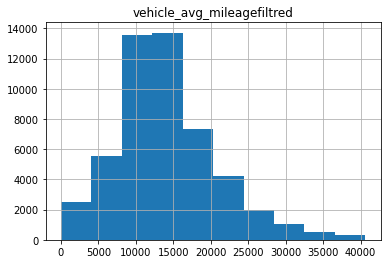

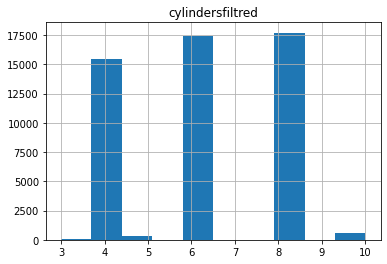

<Figure size 432x288 with 0 Axes>

In [21]:
for i in ['price','ad_placed','vehicle_avg_mileage','cylinders']:
    #data without outliers
    data3=data[(np.abs(stats.zscore(data[i])) < 3)]
    data3[i].hist()
    plt.title(i+'filtred')
    plt.figure()

Using this Z-score method removes then need to study outliers, as anything above a Z-score of 3 is an outlier. If I want access to the outlier data. Outlier_data contains this data. Can using the corr method be a replacement to analyzing histograms? As analyzing the histograms might result in human error on my part. 


## I have used z_score to eliminate outliers and stock data without outliers on data3

<AxesSubplot:xlabel='odometer', ylabel='conditional_values'>

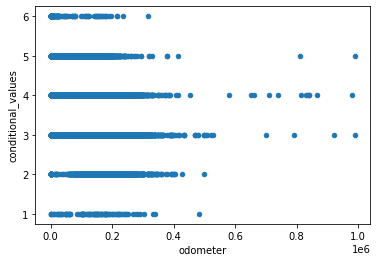

In [22]:
#
data.plot.scatter(x='odometer', y='conditional_values')


<AxesSubplot:>

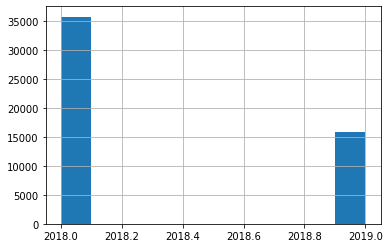

In [23]:
#
data['ad_placed'].hist()
#dates = matplotlib.dates.date2num('ad_placed')
#matplotlib.pyplot.plot_date(dates, 'price')

In [24]:
#
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   price                 51525 non-null  int64         
 1   model_year            51525 non-null  int64         
 2   model                 51525 non-null  object        
 3   condition             51525 non-null  object        
 4   cylinders             51525 non-null  float64       
 5   fuel                  51525 non-null  object        
 6   odometer              51524 non-null  float64       
 7   transmission          51525 non-null  object        
 8   type                  51525 non-null  object        
 9   paint_color           51525 non-null  object        
 10  is_4wd                51525 non-null  bool          
 11  date_posted           51525 non-null  object        
 12  days_listed           51525 non-null  int64         
 13  date_posted_date

## Study and treat outliers


In [25]:
# Determine the lower limits for outliers
lower=[]
for i in [ 'price','vehicle_age_for_ad','vehicle_avg_mileage','cylinders','conditional_values']:
    lower .append( data[i].mean() -3*data[i].std())
lower

[-17989.944126388116,
 -8.82543237662893,
 -11431.06656979265,
 1.148697875228816,
 1.500193460042242]

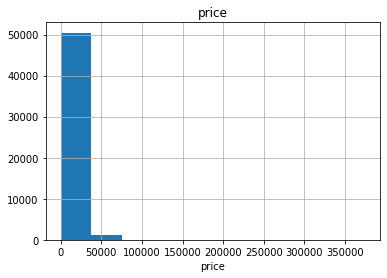

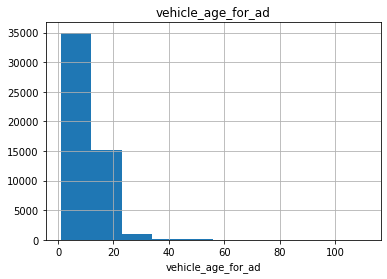

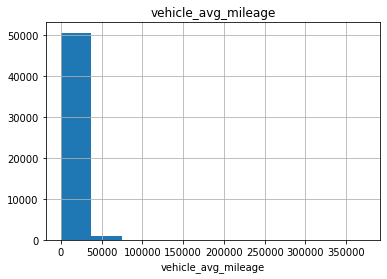

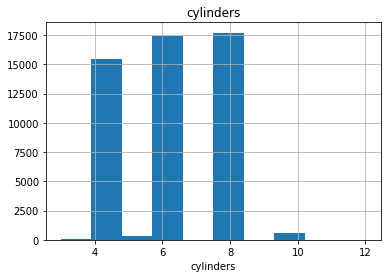

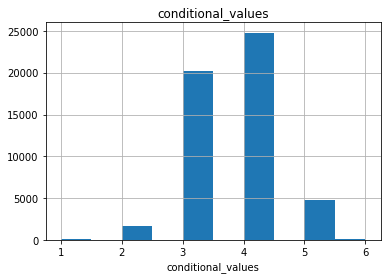

<Figure size 432x288 with 0 Axes>

In [26]:
# Determine the upper limits for outliers
upper=[]
for i in ['price','vehicle_age_for_ad','vehicle_avg_mileage','cylinders','conditional_values']:
    upper.append(data[i].mean() + 3*data[i].std())
upper
for i in ['price','vehicle_age_for_ad','vehicle_avg_mileage','cylinders','conditional_values']:
    data[i].hist()
    plt.title(i)
    plt.xlabel(i)
    plt.figure()

The code snippet:
lower=[]
for i in [ 'price','vehicle_age_for_ad','vehicle_avg_mileage','cylinders','conditional_values']:
    lower .append( data[i].mean() -3*data[i].std())
lower
upper=[]
for i in ['price','vehicle_age_for_ad','vehicle_avg_mileage','cylinders','conditional_values']:
    upper.append(data[i].mean() + 3*data[i].std())
upper
These remove outliers. Then I went ahead and printed the graphs for those columns. Doesnt seem like this had much effect as I had accidentally gotten ahead of myself in a earler section and checked and removed outliers in some columns.

## Study core parameters without outliers

In [27]:
data.corr()
# Excluding values that extend into the outlier terriory(Z-scores above or equal to 3)
# Shows an increase in correlation in price/model_year, as well as in price/is_4wd,
# a negative increase in odometer/price
#

,price,model_year,cylinders,odometer,is_4wd,days_listed,ad_placed,vehicle_age_for_ad,vehicle_avg_mileage,conditional_values,paint_color_values
price,1.000000,0.412969,0.300342,-0.423622,0.315145,-0.000682,0.004726,-0.411669,0.146455,0.221518,-0.075426
model_year,0.412969,1.000000,-0.148119,-0.486935,0.039103,-0.005321,0.008333,-0.997135,0.432800,0.269698,-0.116505
cylinders,0.300342,-0.148119,1.000000,0.091453,0.407298,0.003181,-0.000329,0.147708,-0.031314,-0.065661,-0.005472
odometer,-0.423622,-0.486935,0.091453,1.000000,0.031365,0.002708,-0.006627,0.485255,0.236989,-0.292016,0.061727
is_4wd,0.315145,0.039103,0.407298,0.031365,1.000000,0.002003,-0.002476,-0.039150,0.056645,0.012856,-0.005168
days_listed,-0.000682,-0.005321,0.003181,0.002708,0.002003,1.000000,0.011273,0.006175,-0.006698,-0.002404,0.004466
ad_placed,0.004726,0.008333,-0.000329,-0.006627,-0.002476,0.011273,1.000000,0.067191,-0.127237,0.003788,0.000253
vehicle_age_for_ad,-0.411669,-0.997135,0.147708,0.485255,-0.039150,0.006175,0.067191,1.000000,-0.441464,-0.268790,0.116262
vehicle_avg_mileage,0.146455,0.432800,-0.031314,0.236989,0.056645,-0.006698,-0.127237,-0.441464,1.000000,0.039891,-0.054217
conditional_values,0.221518,0.269698,-0.065661,-0.292016,0.012856,-0.002404,0.003788,-0.268790,0.039891,1.000000,-0.046413


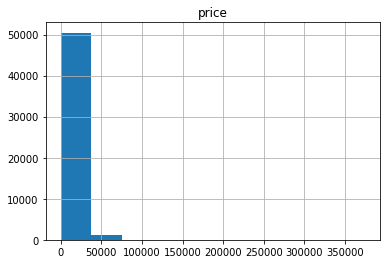

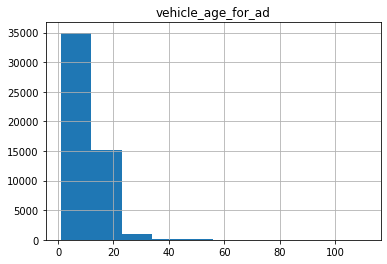

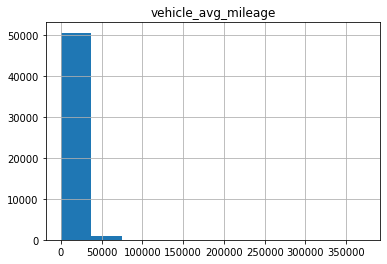

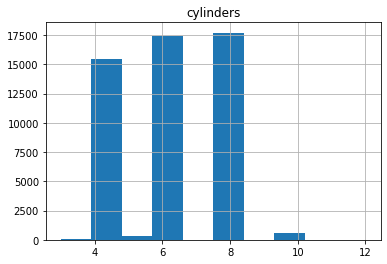

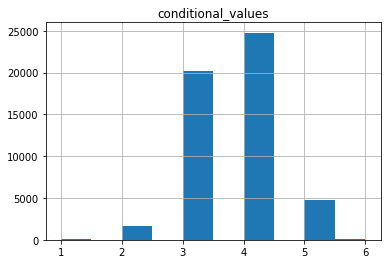

<Figure size 432x288 with 0 Axes>

In [28]:
for i in ['price','vehicle_age_for_ad','vehicle_avg_mileage','cylinders','conditional_values']:
    data[i].hist()
    plt.title(i)
    plt.figure()

## Ads lifetime

[Study how many days advertisements were displayed (`days_listed`). Calculate the mean and median. Describe the typical lifetime of an ad. Determine when ads were removed quickly, and when they were listed for an abnormally long time.]

In [29]:
print(data['days_listed'].mean())
print(data['days_listed'].median())
print(data['days_listed'].min())
print(data['days_listed'].max())
print('Ads removed quickly')
print(data[data['days_listed']<data['days_listed'].mean()])
print('Ads listed for an abnormally long time')
data[data['days_listed']>data['days_listed'].mean()]

39.55475982532751
33.0
0
271
Ads removed quickly
       price  model_year             model  condition  cylinders fuel  \
0       9400        2011            bmw x5       good        6.0  gas   
3       1500        2003        ford f-150       fair        8.0  gas   
4      14900        2017      chrysler 200  excellent        4.0  gas   
5      14990        2014      chrysler 300  excellent        6.0  gas   
8      11500        2012       kia sorento  excellent        4.0  gas   
...      ...         ...               ...        ...        ...  ...   
51514   4800        2012  volkswagen jetta       good        4.0  gas   
51520   9249        2013     nissan maxima   like new        6.0  gas   
51521   2700        2002       honda civic    salvage        4.0  gas   
51522   3950        2009    hyundai sonata  excellent        4.0  gas   
51524   6300        2014     nissan altima       good        4.0  gas   

            odometer transmission    type    paint_color  is_4wd date_post

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,date_posted_datetime,model_year_datetime,ad_placed,vehicle_age_for_ad,vehicle_avg_mileage,conditional_values,paint_color_values
1,25500,2011,ford f-150,good,6.0,gas,88705.000000,automatic,pickup,white,True,2018-10-19,50,2018-10-19,1970-01-01 00:00:00.000002011,2018,8,11088,3,4
2,5500,2013,hyundai sonata,like new,4.0,gas,110000.000000,automatic,sedan,red,False,2019-02-07,79,2019-02-07,1970-01-01 00:00:00.000002013,2019,7,15714,5,5
6,12990,2015,toyota camry,excellent,4.0,gas,79212.000000,automatic,sedan,white,False,2018-12-27,73,2018-12-27,1970-01-01 00:00:00.000002015,2018,4,19803,4,4
7,15990,2013,honda pilot,excellent,6.0,gas,109473.000000,automatic,SUV,black,True,2019-01-07,68,2019-01-07,1970-01-01 00:00:00.000002013,2019,7,15639,4,1
15,17990,2013,ram 1500,excellent,8.0,gas,102880.891908,automatic,pickup,red,True,2018-05-15,111,2018-05-15,1970-01-01 00:00:00.000002013,2018,6,17146,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51516,8999,2011,jeep grand cherokee,good,6.0,gas,124883.614978,automatic,SUV,white,True,2018-11-01,51,2018-11-01,1970-01-01 00:00:00.000002011,2018,8,15610,3,4
51517,11000,2012,dodge charger,excellent,8.0,gas,81000.000000,automatic,sedan,black,False,2019-04-19,44,2019-04-19,1970-01-01 00:00:00.000002012,2019,8,10125,4,1
51518,3750,2005,ford taurus,excellent,6.0,gas,110200.000000,automatic,sedan,silver,False,2018-08-10,63,2018-08-10,1970-01-01 00:00:00.000002005,2018,14,7871,4,3
51519,11750,2015,honda accord,excellent,4.0,gas,82503.819348,automatic,coupe,Unknown Color,False,2018-11-24,89,2018-11-24,1970-01-01 00:00:00.000002015,2018,4,20625,4,0


Ads Lifetime Conculsion:
The data represented here shows the data that was listed for a upbove mean time. There are 20908 rows of data that are over the mean. 

## Average price per each type of vehicle

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

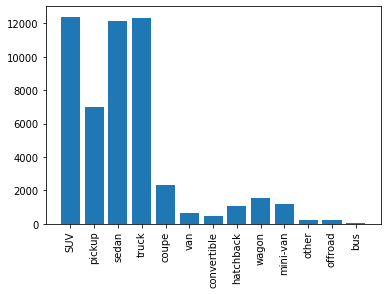

In [30]:
plt.bar(list(data['type'].unique()),[len(data[data['type']==i]) for i in list(data['type'].unique())])
plt.xticks(rotation='vertical')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

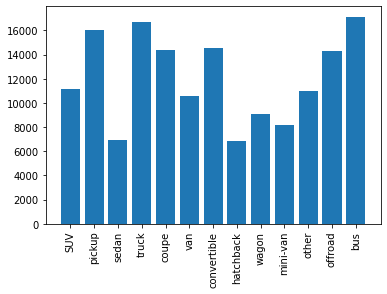

In [31]:
plt.bar(list(data['type'].unique()),[data[data['type']==i]['price'].mean() for i in list(data['type'].unique())])
plt.xticks(rotation='vertical')

Text(0.5, 1.0, 'Number of days')

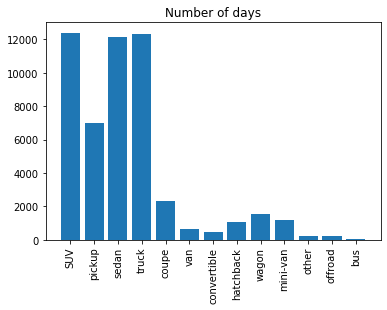

In [32]:
s=[]
for i in data['type'].unique():
    s.append(data[data['type']==i]['days_listed'].count())
plt.bar(data['type'].unique(),s)
plt.xticks(rotation=90)
plt.title('Number of days')

Text(0.5, 1.0, 'Number of days')

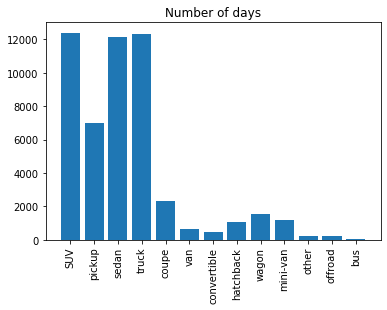

In [33]:
w=[]
for i in data['type'].unique():
    w.append(data[data['type']==i]['price'].mean())
plt.bar(data['type'].unique(),s)
plt.xticks(rotation=90)
plt.title('Number of days')

In [34]:
#We have SUV, sedan and truck have the most number of ads

## Price factors

In [35]:
data.corr()
# Model_year, and 4wd are the most correlated factors to price.
#data2.boxplot(column='color')

,price,model_year,cylinders,odometer,is_4wd,days_listed,ad_placed,vehicle_age_for_ad,vehicle_avg_mileage,conditional_values,paint_color_values
price,1.000000,0.412969,0.300342,-0.423622,0.315145,-0.000682,0.004726,-0.411669,0.146455,0.221518,-0.075426
model_year,0.412969,1.000000,-0.148119,-0.486935,0.039103,-0.005321,0.008333,-0.997135,0.432800,0.269698,-0.116505
cylinders,0.300342,-0.148119,1.000000,0.091453,0.407298,0.003181,-0.000329,0.147708,-0.031314,-0.065661,-0.005472
odometer,-0.423622,-0.486935,0.091453,1.000000,0.031365,0.002708,-0.006627,0.485255,0.236989,-0.292016,0.061727
is_4wd,0.315145,0.039103,0.407298,0.031365,1.000000,0.002003,-0.002476,-0.039150,0.056645,0.012856,-0.005168
days_listed,-0.000682,-0.005321,0.003181,0.002708,0.002003,1.000000,0.011273,0.006175,-0.006698,-0.002404,0.004466
ad_placed,0.004726,0.008333,-0.000329,-0.006627,-0.002476,0.011273,1.000000,0.067191,-0.127237,0.003788,0.000253
vehicle_age_for_ad,-0.411669,-0.997135,0.147708,0.485255,-0.039150,0.006175,0.067191,1.000000,-0.441464,-0.268790,0.116262
vehicle_avg_mileage,0.146455,0.432800,-0.031314,0.236989,0.056645,-0.006698,-0.127237,-0.441464,1.000000,0.039891,-0.054217
conditional_values,0.221518,0.269698,-0.065661,-0.292016,0.012856,-0.002404,0.003788,-0.268790,0.039891,1.000000,-0.046413


In [36]:
data_SUV_and_Sedan = data[(data['type'] == 'SUV') | (data['type'] == 'sedan')]



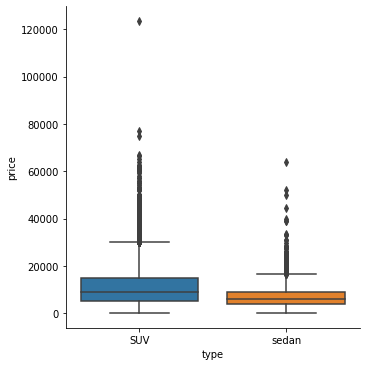

In [37]:
import seaborn as sns
sns.catplot(data=data_SUV_and_Sedan, x='type', y='price', kind="box")


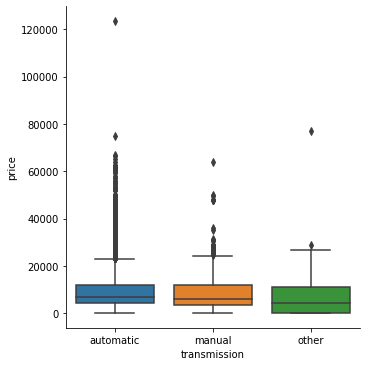

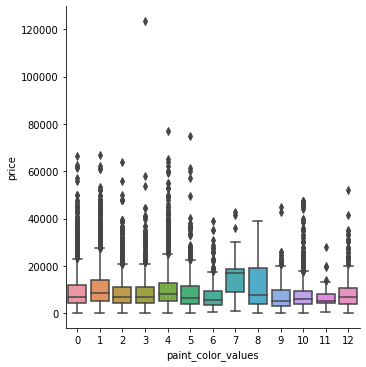

In [50]:
for i in ['transmission','paint_color_values']:
       sns.catplot(data=data_SUV_and_Sedan, x=i, y='price', kind="box")

<AxesSubplot:xlabel='type', ylabel='cylinders'>

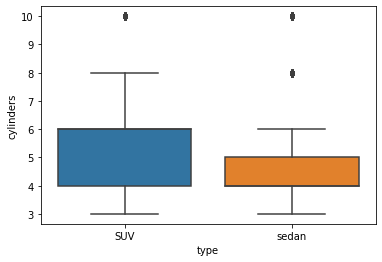

In [48]:
sns.boxplot(data=data_SUV_and_Sedan, x="type", y="cylinders")

<AxesSubplot:xlabel='type', ylabel='paint_color_values'>

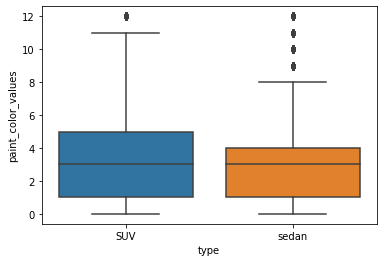

In [49]:
sns.boxplot(data=data_SUV_and_Sedan, x="type", y="paint_color_values")

Graph Breakdown:
    3 Histograms overlade each other that show the popularity of suv, sedans and trucks
    3 Scatterplots that compare price to other variables
    3 Catplots that compare color, transmission, and type of vehicle to price.

## General conclusion

In this project we attempted to find what correlates to the price of a used vechile on the open market.I found that price and model_year reading is the most correlated measurement. The higher the model_year reading, the lower the value. Using a z-score apporach to removing outliers I learned works the quickest. I had assumed model_year would be the most correlated to price. I was correct. I was surpised to find that 4wd was also correlated, at least on a lower level. Missing values in most columns were converted into either the mean or median of the rest of the data after searching thorught the data's histograms

General Conclusion:
We have analyzed the data in vehicles_us.csv. The dataset had many missing values which we fixed with multiple techniques. We did this because we are a analyst for Crankshaft List and needed to determine the atributes of an advertisment. We learned that the price of a listed vehicle has many factors. Color, type, transmisin. The most correlated factor to price was odometer reading however.